# PRÁTICA GUIADA: KNN

## Introdução

Nesta prática, a KNN será usada para resolver um problema de classificação.


Os seguintes passos serão realizados:

1. Carregar o conjunto de dados

2. Preparar a matriz de recursos e o vetor de targets

3. Escolher o valor ideal para o hiperparâmetro n_neighbours, utilizando VALIDAÇÃO CRUZADA

4. Repetir o processo, porém, padronizando a matriz de recursos para ver os efeitos sobre o algoritmo 

5. Matriz de confusão

## 1 - Importar o conjunto de dados

O conjunto de dados market.csv contém dados sobre as ações que compõem o índice S &amp; P 500 retirado do site do Yahoo Finance entre 2000 e 2001.

A seguir, uma descrição das colunas:

* **Lag1:** Percentage return for previous day
* **Lag2:** Percentage return for 2 days previous
* **Lag3:** Percentage return for 3 days previous
* **Lag4:** Percentage return for 4 days previous
* **Lag5:** Percentage return for 5 days previous
* **Volume:** Volume of shares traded (number of daily shares traded in billions)
* **Today:** Percentage return for today
* **Direction:** A factor with levels Down and Up indicating whether the market had a positive or negative
return on a given day


In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('market.csv')

In [4]:
df.sample(5)

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
323,-1.01,-1389.00,-152.00,-0.71,-0.62,1.31470,1077.0,Up
38,998.00,586.00,-568.00,104.00,-1431.00,1.09180,645.0,Up
1077,-884.00,866.00,-675.00,1974.00,-1325.00,1.95974,395.0,Up
701,216.00,-0.47,331.00,-1498.00,129.00,1.37180,1519.0,Up
446,-1063.00,1733.00,0.59,2.23,-2411.00,1.54920,672.0,Up


## 2 - Construir a matriz de recursos e o vetor de targets

In [5]:
df.columns

Index(['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction'], dtype='object')

In [6]:
# Construir a matriz de recursos, subconfigurando o DataFrame para que não contenha a classe, Direction
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]

#### Tornando numérico o vetor de targets
O vetor de targets foi codificado com os valores possíveis de 'Up' ou 'Down', mas lembre-se que scikitlearn só aceita valores numéricos (mesmo que eles representem classes), portanto, sempre temos que dar uma tag numérica às classes, se aceitarem dois valores possíveis ou mais.
Isso é feito com a classe LabelEncoder()

In [7]:
# Construir o vetor de targets
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Direction'])
y

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

## 3 - Avaliar diferentes valores para o hiperparâmetro

Agora será executado o modelo KNeighborsClassifier testando diferentes valores possíveis para o hiperparâmetro n_neighbors.


In [8]:
from sklearn.model_selection import cross_val_score

# Queremos representar graficamente os diferentes valores de score de validação cruzada em função do hiperparâmetro n_neighbors
# Para isso, gerar uma lista de dicionários que depois podem ser facilmente convertidos a DataFrame

#Lista de Dicionários
scores_para_df = []

# range(1,40,5) são os valores possíveis de n_neighbors que queremos explorar. São todos os inteiros de 1
# a 40, de 5 em 5. (Start,Stop,Step)
for i in range(1,100,5):
    # Em cada iteração, instanciar o modelo com um hiperparâmetro diferente
    model = KNeighborsClassifier(n_neighbors=i)
    
    # cross_val_scores retorna um array de 5 resultados, um para cada partição feita automaticamente pelo CV  
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Para cada valor de n_neighbours, criar um dicionário com o valor de n_neighbours, a média e o desvio dos scores.
    dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}
    
    # Guardar cada um na lista de dicionários
    scores_para_df.append(dict_row_score)

In [9]:
# Criar o DataFrame a partir da lista de dicionários
df_scores = pd.DataFrame(scores_para_df)
df_scores.head()

,n_neighbours,score_medio,score_std
0,1,0.500131,0.047463
1,6,0.484038,0.024568
2,11,0.508061,0.031359
3,16,0.500864,0.023810
4,21,0.511238,0.025397


#### Representando graficamente a procura pelo melhor hiperparâmetro

O valor de pontuação que utiliza KNeighborsClassifier por default é o accuracy:
#casos bem classificados / #total.

Uma vez que temos o DataFrame com o desempenho de cada valor do hiperparâmetro, fazemos um gráfico com os valores. Para ter uma ideia da dispersão, também representar graficamente as linhas que indicam um desvio padrão acima e abaixo da média





In [10]:
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']

In [11]:
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

In [12]:
df_scores.head()

,n_neighbours,score_medio,score_std,limite_inferior,limite_superior
0,1,0.500131,0.047463,0.452668,0.547594
1,6,0.484038,0.024568,0.459470,0.508606
2,11,0.508061,0.031359,0.476702,0.539419
3,16,0.500864,0.023810,0.477054,0.524674
4,21,0.511238,0.025397,0.485841,0.536636


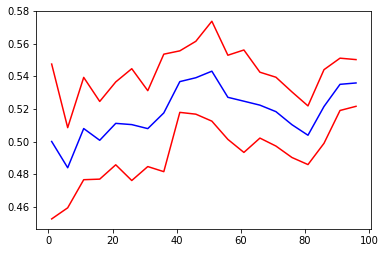

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r');

## 4 - Padronização das variáveis

Foi dito que o KNN é um método de Machine Learning que se baseia em medições de distância. Embora 6 de nossas 7 variáveis estejam nas mesmas unidades, uma delas não está: a variável Volume.

Para dar maior interpretabilidade matemática ao processo que está sendo feito, o correto seria padronizar as variáveis para se desfazer das unidades físicas.

In [14]:
# Utilizar sklearn para padronizar a matriz de Features
from sklearn import preprocessing
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]
X = preprocessing.scale(X, axis = 0)

In [15]:
# Verificar se as colunas têm média 0 e desvio 1.
print('media:',np.mean(X[:,1]))
print('desvio:',np.std(X[:,1]))

media: 2.842170943040401e-18
desvio: 1.0


In [32]:
# Calcular os scores de validação cruzada novamente, mas desta vez sobre os recursos padronizados
from sklearn.model_selection import cross_val_score
scores_para_df_standar = []
for i in range(1,100,5):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X, y, cv=5)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores),
                      'n_neighbours':i}
    
    scores_para_df_standar.append(dict_row_score)

In [33]:
df_scores_standar = pd.DataFrame(scores_para_df_standar)
df_scores_standar.head(10)

,n_neighbours,score_medio,score_std
0,1,0.500131,0.047463
1,6,0.482438,0.024114
2,11,0.509667,0.034981
3,16,0.500064,0.024804
4,21,0.509638,0.027123
5,26,0.510477,0.032848
6,31,0.508022,0.025608
7,36,0.517648,0.036809
8,41,0.536032,0.016335
9,46,0.540807,0.021747


In [18]:
# Criar os limites para representação gráfica novamente
df_scores_standar['limite_superior'] = df_scores_standar['score_medio'] + df_scores_standar['score_std']
df_scores_standar['limite_inferior'] = df_scores_standar['score_medio'] - df_scores_standar['score_std']

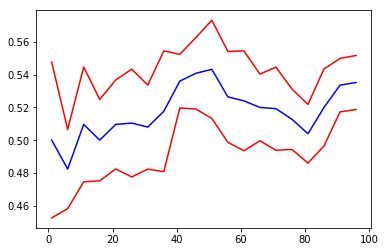

In [19]:
# Buscar graficamente o valor ideal para n_neighbors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_inferior'],color='r')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['score_medio'],color='b')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_superior'],color='r');

#### Avaliando os resultados

Neste caso, vemos que a padronização não gera nenhuma alteração significativa nos resultados do modelo
Por que observamos isso?
Porque neste modelo todas as variáveis são expressas nas mesmas unidades, por isso, não é necessário redimensionar cada um dos componentes para construir uma matriz de distância que faça sentido.

## 5 - Matriz de confusão

Agora que foi decidido qual é o melhor pré-processamento e o melhor valor possível para os hiperparâmetros, é possível treinar um modelo com esses critérios para obter uma matriz de confusão sobre os dados não observados. 

### 5.1- Pré-processamento dos dados
(Repetir os passos acima apenas para tornar todo o processo mais claro)

In [20]:
# Matriz de features
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]
X = preprocessing.scale(X, axis = 0)

# Vetor de targets
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Direction'])

### 5.2- Split train-test

Já sabendo qual é o melhor modelo, queremos obter uma matriz de confusão. Fazer um novo split train-test porque sempre queremos avaliar onde o modelo faz previsões corretas e onde ele comete erros ** sobre dados não observados ou seja, novos dados **

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [26]:
# Escolher o modelo ideal que foi indicado pela validação cruzada
model = KNeighborsClassifier(n_neighbors=51)

# Ajustá-lo sobre os dados de treinamento
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=51, p=2,
           weights='uniform')

In [27]:
# Ele é utilizado para prever em teste
y_pred = model.predict(X_test)

In [24]:
# Elaborar a matriz de confusão:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[71, 85],
       [60, 97]], dtype=int64)

In [28]:
# Elaborar a matriz de confusão:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 59,  91],
       [ 56, 107]], dtype=int64)

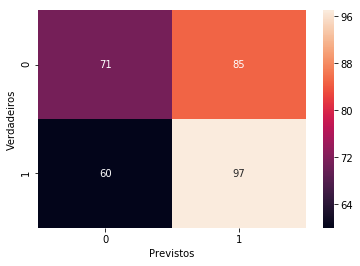

In [25]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Verdadeiros')
plt.xlabel('Previstos');

In [26]:
# Lembrar dos valores dos rótulos que foram criados com o método LabelEncoder()
le.classes_

array(['Down', 'Up'], dtype=object)

Conclusão: Não parece ser fácil prever a evolução das ações com base nos recursos utilizados. O modelo tem um viés para prever que as ações vão subir. 